In [9]:
from skimage import feature, io, color, util, segmentation, transform, draw, img_as_ubyte, measure, img_as_bool, filters
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from scipy import optimize
from skimage.morphology import disk, dilation, erosion, square, closing
from scipy import ndimage as ndi

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

In [99]:
images_dir = 'Dataset/consumer'
filename = '!!VRD847QII0ER062-GZ-8Q_2Z-S1_.JPG'

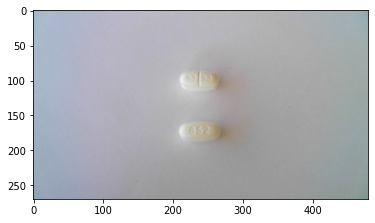

In [100]:
image_orig = io.imread(os.path.join(images_dir, filename))
if image_orig.shape[-1] == 4:
    image_orig = image_orig[:,:,:3]
# image = image_orig
image = transform.resize(image_orig, (int(image_orig.shape[0] * (480 / image_orig.shape[1])), 480), anti_aliasing=True)
plt.imshow(image)

/home/mirko/Envs/pill-classification/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  if __name__ == '__main__':


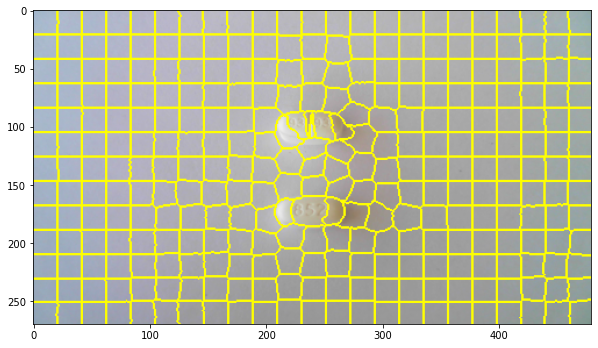

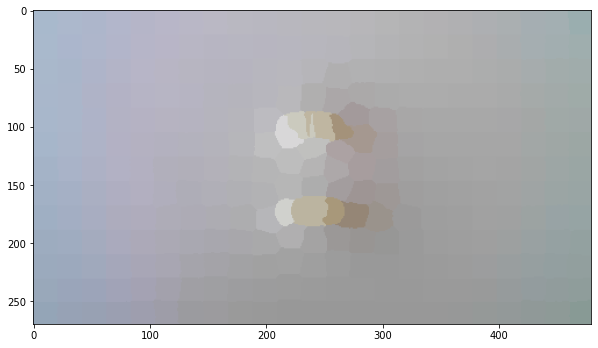

In [101]:
img = util.img_as_float(image)
img_slic = segmentation.slic(img, n_segments=300, compactness=10, sigma=1, start_label=1)

plt.figure(figsize=(10,10))

plt.imshow(segmentation.mark_boundaries(img, img_slic))

regions = regionprops(img_slic)
label_rgb = color.label2rgb(img_slic, img, kind='avg')

plt.figure(figsize=(10,10))

plt.imshow(label_rgb)

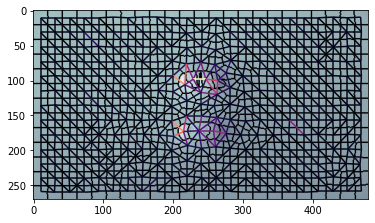

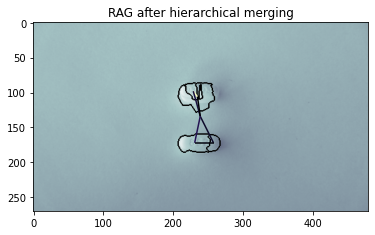

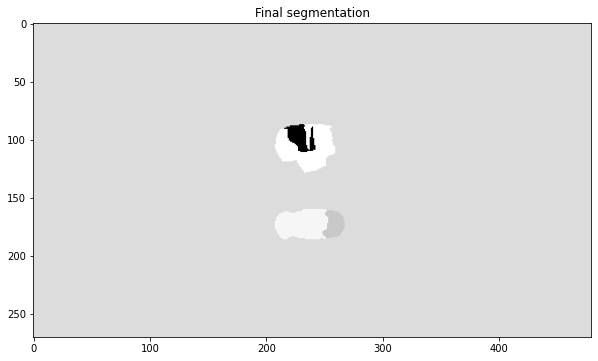

In [103]:
from skimage.future import graph
# rag = graph.rag_mean_color(img, img_slic)

def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary region adjacency graph.

    This function computes the `"weight"` and the count `"count"`
    attributes of the edge between `n` and the node formed after
    merging `src` and `dst`.


    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes to be
        assigned for the merged node.

    """
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }


def merge_boundary(graph, src, dst):
    """Call back called before merging 2 nodes.

    In this case we don't need to do any computation here.
    """
    pass

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])


edges = filters.sobel(color.rgb2gray(img))

# rag = graph.rag_mean_color(img, img_slic)

rag = graph.rag_boundary(img_slic, edges)

graph.show_rag(img_slic, rag, img)

#labels2 = graph.cut_normalized(img_slic, rag)

labels2 = graph.merge_hierarchical(img_slic, rag, thresh=0.03, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

#labels2 = graph.merge_hierarchical(img_slic, rag, thresh=0.05, rag_copy=False,
#                                   in_place_merge=True,
#                                   merge_func=merge_mean_color,
#                                   weight_func=_weight_mean_color)
# labels2 = graph.cut_threshold(img_slic, rag, 29)
graph.show_rag(img_slic, rag, img)
plt.title('RAG after hierarchical merging')

plt.figure(figsize=(10,10))
out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
plt.imshow(color.rgb2gray(out), cmap='gray')
plt.title('Final segmentation')

plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

n_colors = 3

image = np.array(image_orig, dtype=np.float64) / 255
image = transform.resize(image, (int(image_orig.shape[0] * (480 / image_orig.shape[1])), 480), anti_aliasing=True)
plt.imshow(image)

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
print(w,h,d)
assert d == 3
image_array = np.reshape(image, (w * h, d))

print("Fitting model on a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)

codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")

labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)

def recreate_image(codebook, labels, w, h):
    # Recreate the (compressed) image from the code book & labels
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
image_knn = recreate_image(kmeans.cluster_centers_, labels, w, h)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, disk
from skimage.color import label2rgb, rgb2gray

image = rgb2gray(image_knn)

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image <= thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 200:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
image_gs = color.rgb2gray(image_knn)
plt.imshow(image_gs, cmap='gray')

In [ ]:
blurred = filters.gaussian(image_knn, sigma=5)
plt.imshow(blurred)

In [ ]:

thresh = filters.threshold_otsu(image_gs)

bw = closing(image_gs <= thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# edges = filters.sobel(image_gs)
edges = feature.canny(image_gs, sigma=1, low_threshold=0, high_threshold=0.1)
plt.figure(figsize=(10,8))

selem = disk(3)

dilated = dilation(edges, selem)

filled = ndi.binary_fill_holes(edges)

fig, axes = plt.subplots(1, 4, figsize=(10,8), sharey=True)
axes[0].imshow(cleared, cmap='gray')
axes[1].imshow(edges, cmap='gray')
axes[2].imshow(dilated, cmap='gray')
axes[3].imshow(filled, cmap='gray')

for a in axes:
    a.axis('off')

plt.tight_layout()

In [ ]:
# TEMPLATE MATCHING

import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import match_template

coin = io.imread(os.path.join(images_dir, 'ellipse.png'))

coin = transform.resize(coin, (int(coin.shape[0] * (64 / coin.shape[1])), 64), anti_aliasing=True)
image = rgb2gray(image)
coin = rgb2gray(coin)
print(image.shape)
print(coin.shape)

result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(coin, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

img = rgb2gray(filled)

s = np.linspace(0, 2*np.pi, 400)
r = y +16 + 64*np.sin(s)
c = x +32 + 64*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.001, beta=0, w_edge=1, w_line=0, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.plot(x, y, '.g')
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

(164, 2)


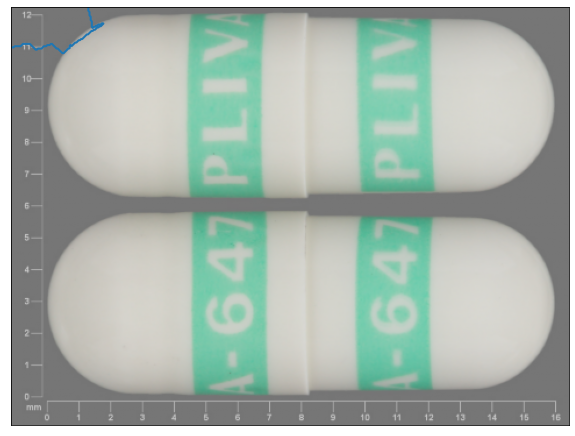

In [51]:
from skimage import measure

# Construct some test data

# Find contours at a constant value of 0.8
contours = measure.find_contours(color.rgb2gray(out), 0.2)

if len(contours) != 0:
    # Display the image and plot all contours found
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
       # ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        pass

    contours.sort(key=len)

    print(contours[-1].shape)

    ax.plot(contours[-1][:,1], contours[-1][:,0], lw=2)

    coords = contours[-1]

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [8]:
mask = draw.polygon2mask(image_gs.shape, coords)
plt.imshow(mask, cmap='gray')

NameError: name 'image_gs' is not defined

In [ ]:
label_img = label(mask)
regions = regionprops(label_img)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    if props.area >= 200:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax.plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=2.5)

plt.show()

In [ ]:
edges = feature.canny(gs, sigma=2, low_threshold=0, high_threshold=0.3)

selem = disk(6)

dilated = dilation(edges, selem)

filled = ndi.binary_fill_holes(dilated)

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
axes[0].imshow(gs, cmap=plt.cm.gray)
axes[1].imshow(edges, cmap='gray')
axes[2].imshow(dilated, cmap='gray')
axes[3].imshow(filled, cmap='gray')

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

In [ ]:
label_img = label(filled)
regions = regionprops(label_img)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

plt.show()

In [ ]:
markers = np.zeros_like(gs)
markers[gs < 0.5] = 1
markers[gs > 0.5] = 2

from skimage.filters import sobel
elevation_map = sobel(gs)

plt.imshow(elevation_map)

from skimage.segmentation import watershed
segmentation = watershed(elevation_map, markers)
plt.imshow(segmentation, cmap='gray')

from skimage.color import label2rgb

segmentation_coins = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation_coins)
image_label_overlay = label2rgb(labeled_coins, image=image, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].contour(segmentation_coins, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()


In [ ]:
edges = feature.canny(gs, sigma=2, low_threshold=0, high_threshold=0.3)
plt.imshow(edges, cmap=plt.cm.gray)

image_1 = img_as_bool(edges)
plt.imshow(image_1, cmap=plt.cm.gray)

In [ ]:
from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert

# The original image is inverted as the object must be white.
image = edges
chull = convex_hull_image(image)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_axis_off()

ax[1].set_title('Transformed picture')
ax[1].imshow(chull, cmap=plt.cm.gray)
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
regions = measure.regionprops(image_1.astype('uint8'))
bubble = regions[0]

y0, x0 = bubble.centroid
r = bubble.major_axis_length / 2.

def cost(params):
    x0, y0, r = params
    coords = draw.circle(y0, x0, r, shape=image_1.shape)
    template = np.zeros_like(image_1)
    template[coords] = 1
    return -np.sum(template == image_1)

x0, y0, r = optimize.fmin(cost, (x0, y0, r))

f, ax = plt.subplots()
circle = plt.Circle((x0, y0), r)
ax.imshow(image_1, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
plt.show()

In [ ]:
"""
pic_n = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
kmeans = KMeans(n_clusters=3, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(image.shape[0], image.shape[1], image.shape[2])
plt.imshow(cluster_pic.astype('uint8'))
"""